In [5]:
%load_ext autoreload

%reload_ext autoreload
%autoreload 2

In [86]:
import numpy as np
import logging

logging.basicConfig()
np.random.seed(0)
num_episodes = 3000

In [87]:
import gymnasium as gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)#, render_mode='human')
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    break

    if terminated or truncated:
        observation, info = env.reset()
    print(observation, action)

# env.close()

In [88]:
import numpy as np

In [89]:
from d3rlpy.lcb.online import ValueIteration
policy_fn, vi_info = ValueIteration(env).run()

In [90]:
nb_states = env.observation_space.n       # number of possible states
nb_actions = env.action_space.n      # number of actions from each state

## Creating an offline dataset
Now try sampling optimal policy to create an offline dataset

In [91]:
policy_fn([2])

3

In [92]:
from d3rlpy.lcb.dsd_algos import OfflineVI
from d3rlpy.lcb.util import CreateOfflineDataset

In [93]:
creator = CreateOfflineDataset(env, 200,num_episodes, 0)

In [94]:
ds = creator.generate_full_dataset(policy_fn, 0, gymnasium=True)

In [95]:
def count_unique_sa(ds):
    visited_sa = set()
    for ep in ds:
        for transition in ep:
            o, a, rw, o_next, done = transition.observation, transition.action, transition.reward, \
                    transition.next_observation, transition.terminal
            visited_sa.add((o[0],a))
    print(len(visited_sa))
    return visited_sa

def test_ds(ds, P_mat):
    for ep in ds.episodes:
        for transition in ep:
            o, a, rw, o_next, done = transition.observation, transition.action, transition.reward, \
                transition.next_observation, transition.terminal

            o = int(o[0])
            o_next = int(o_next[0])

            if P_mat[(o,a,o_next)] == 0:
                return (o,a,o_next)
    return None
        

visited_sa = count_unique_sa(ds)

44


In [96]:
known_p=True

In [97]:
off_vi = OfflineVI(env, ds)

In [98]:
off_policy, off_V_s, off_info = off_vi.offline_value_iteration(N=ds.dataset_size, Lc=1e-3, V_max=1, known_P=known_p)

mb_size154 t1215 batch_size154 T 1214
dataset_size188133 vs 186956


In [99]:
env.env.P[6][0]

[(0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 10, 0.0, False)]

In [100]:
test_ds(ds,off_vi.P_mat)

In [101]:
# Testing ds 
batch_size = 114
visited_sa = set()
for t,mb in enumerate(ds.get_dataset_batches(batch_size=batch_size)):
#     if t > 1180:
#         break
    for transition in mb:
        visited_sa.add((int(transition.observation[0]), transition.action))
print(t, visited_sa)

1649 {(4, 0), (4, 3), (14, 1), (3, 1), (9, 2), (8, 0), (8, 3), (10, 0), (0, 2), (2, 2), (13, 2), (1, 0), (10, 3), (1, 3), (6, 2), (4, 2), (14, 0), (3, 0), (3, 3), (14, 3), (8, 2), (9, 1), (10, 2), (0, 1), (1, 2), (2, 1), (13, 1), (6, 1), (3, 2), (14, 2), (4, 1), (9, 0), (9, 3), (0, 0), (8, 1), (1, 1), (0, 3), (10, 1), (13, 0), (2, 0), (2, 3), (13, 3), (6, 0), (6, 3)}


In [102]:
ds.dataset_size

188133

In [103]:
off_V_s

array([0.        , 0.        , 0.        , 0.        , 0.04186967,
       0.        , 0.06443674, 0.        , 0.13870093, 0.29863682,
       0.34661594, 0.        , 0.        , 0.50212228, 0.79149708,
       0.        ])

In [104]:
off_policy

array([3, 3, 0, 3, 0, 0, 0, 2, 3, 1, 0, 2, 2, 2, 1, 3])

In [105]:
from d3rlpy.lcb.util import evaluate_policy_on_env

def off_policy_fn(obs):
    return off_policy[obs]

vi_stat = evaluate_policy_on_env(policy_fn,env, gymnasium=True, num_episodes=1000)
off_vi_stat = evaluate_policy_on_env(off_policy_fn, env, gymnasium=True, num_episodes=1000)
print(vi_stat, off_vi_stat)

{'mean': 0.742, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.4375339986789598} {'mean': 0.249, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.4324338099640221}


In [106]:
off_vi.estimatePR.get_batch_mt(-1), off_info['final_penalty']

(array([[[3.3298e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4910e+03, 1.5300e+03, 0.0000e+00, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4720e+03, 1.5290e+03, 0.0000e+00, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.9860e+03, 1.5170e+03, 0.0000e+00, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],
 
        [[5.1200e+02, 5.1800e+02, 0.0000e+00, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [5.1300e+02, 0.0000e+00, 4.9800e+02, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 5.3000e+02, 5.4700e+02, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3670e+03, 1.3240e+03, 1.3470e+03, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],
 
        [[0.0000e+00, 2.4300e+02, 2.4600e+02, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.4900e+02, 0.0000e+00, ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.00

In [107]:
off_V_s

array([0.        , 0.        , 0.        , 0.        , 0.04186967,
       0.        , 0.06443674, 0.        , 0.13870093, 0.29863682,
       0.34661594, 0.        , 0.        , 0.50212228, 0.79149708,
       0.        ])

### Test on general MDP

In [108]:
import mdptoolbox.example
from d3rlpy.envs.env import MDPToolboxEnv


In [144]:
env.spec

EnvSpec(id='Random_4x4-v0', entry_point=None, reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='Random_4x4', version=0, additional_wrappers=(), vector_entry_point=None)

In [145]:
# np.random.seed(0)

def create_random_mdp(S_dim=4,A_dim=4):

    P, R = mdptoolbox.example.rand(S_dim, A_dim)
    
    # For positivity constraint
    P_clip = P.clip(1e-2)
    P_norm = P_clip / np.expand_dims(P_clip.sum(axis=-1), 2) # normalize
    
    consistency_test = (P_norm.sum(axis=-1) + 1e-5).astype(int) == 1
    assert (consistency_test).all()

    return MDPToolboxEnv(P_norm,R, spec_id=f"Random_{S_dim}x{A_dim}")

env = create_random_mdp()
env.P


array([[[0.00970874, 0.97087379, 0.00970874, 0.00970874],
        [0.00970874, 0.00970874, 0.97087379, 0.00970874],
        [0.00970874, 0.97087379, 0.00970874, 0.00970874],
        [0.00970874, 0.00970874, 0.00970874, 0.97087379]],

       [[0.00980392, 0.2166909 , 0.00980392, 0.76370125],
        [0.18569214, 0.24819188, 0.18503573, 0.38108024],
        [0.00980392, 0.00980392, 0.4207007 , 0.55969146],
        [0.97087379, 0.00970874, 0.00970874, 0.00970874]],

       [[0.00970874, 0.00970874, 0.97087379, 0.00970874],
        [0.00988728, 0.00988728, 0.16809896, 0.81212648],
        [0.97087379, 0.00970874, 0.00970874, 0.00970874],
        [0.33036101, 0.10773441, 0.23845661, 0.32344797]],

       [[0.3528263 , 0.0556628 , 0.24665989, 0.34485101],
        [0.17153714, 0.46538342, 0.35317845, 0.00990099],
        [0.00970874, 0.97087379, 0.00970874, 0.00970874],
        [0.10792167, 0.50922643, 0.00990099, 0.37295092]]])

In [110]:
env.P.sum(axis=-1)[1][0]

AttributeError: 'dict' object has no attribute 'sum'

In [111]:
# import mdptoolbox.example
# P, R = mdptoolbox.example.forest()
vi = mdptoolbox.mdp.ValueIteration(env.P, env.R, 0.9)
vi.run()
vi.policy # result is (0, 0, 0)

# from d3rlpy.envs import MDPToolboxEnv

# env = gym.make('MDPToolbox-Forest-Large-v0')

# env.reset()
# for _ in range(10):
#     obs = env.step(0)
# # env.step(0)
# # env.step(0)
# obs

# env.observation_space

# env.action_space

# # Create policy 
def run_vi_and_get_policy(env, gamma=0.9):
    vi = mdptoolbox.mdp.ValueIteration(env.P, env.R, gamma)
    vi.run()
    return lambda state: vi.policy[int(state)] # result is (0, 0, 0)
    

mdp_policy = run_vi_and_get_policy(env)
creator = CreateOfflineDataset(env, 100,300, 0)
ds = creator.generate_full_dataset(mdp_policy, 0, gymnasium=True)
visited_sa = count_unique_sa(ds)

# sum([mdp_policy(i) for i in range(100)])

# mdp_dat = creator._generate_dataset(mdp_policy, 0, gymnasium=True)

# mdp_dat.episode_terminals

AttributeError: 'FrozenLakeEnv' object has no attribute 'R'

In [112]:
# policy_fn = run_vi_and_get_policy(env)

In [113]:
policy_fn(3)

3

## Try KSD 

In [114]:
from d3rlpy.lcb.ksd.model import TabularModel
model = TabularModel(env=env)

In [115]:
model

In [116]:

from d3rlpy.lcb.ksd.kernels import exp_hamming_kernel, exp_hamming_kernel_ij_factory
from d3rlpy.lcb.ksd.ksd import KSD
from d3rlpy.lcb.ksd.ksd_utils import ksd_est, ksd_boot, ksd_pvalue

In [117]:
model.score

<bound method TabularModel.score of <d3rlpy.lcb.ksd.model.TabularModel object at 0x7f137e60a970>>

In [118]:
exp_hamming_kernel_ij = exp_hamming_kernel_ij_factory()

In [119]:
samples_q = np.array([[0], [1]])  # TODO: modify
s_array = np.array([[0],[5],[2]])
sa_array =  np.array([[0, 0],[1, 1],[2, 2]])

def compute_ksd(s_array, sa_array, kernel_fun=exp_hamming_kernel):
    # model = RBM(m, k, W, bvec, cvec)  # Null model
    ksd = KSD(neg_fun=model.neg, score_fun=model.score,
              kernel_fun=kernel_fun, neg_inv_fun=model.neg_inv)  # Use null model
    kappa_vals = ksd.compute_kappa(samples=s_array, sa=sa_array)
    # Compute U-statistics and bootstrap intervals
    return kappa_vals
    ksd_stats, _ = ksd_est([kappa_vals])
    ksd_boot_list, ksd_thres_list = ksd_boot([kappa_vals])
    ksd_pvals = ksd_pvalue(ksd_boot_list, ksd_stats)

    ksd_stat = ksd_stats[0]
    ksd_thres = ksd_thres_list[0]
    ksd_pval = ksd_pvals[0]
    ksd_pred = 1 * (ksd_stat > ksd_thres)  # 0 for p, 1 for q
    return ksd_stat

## Test DSD 

In [120]:
ds.dataset_size

188133

In [121]:

# sa_array =  np.array([[0, 0],[0, 0],[2, 2]])[:2]
s_array = s_array[:2]
sa_array = sa_array[:2]


In [123]:
from d3rlpy.lcb.dsd_algos import OfflineVIwDSD
from d3rlpy.lcb.offvi import OfflineVIwNoPenalty
known_p=False
# logging.getLogger('d3rlpy.lcb.ksd.model').setLevel(logging.INFO)
logging.getLogger('d3rlpy.lcb.lcb').setLevel(logging.INFO)
# logging.getLogger('d3rlpy.lcb.lcb').setLevel(logging.INFO)
off_vi_dsd = OfflineVIwDSD(env, ds, gamma_b=0.3, alpha_b=0.2)#, holdout=0.2)#, gamma_dataset=True)
off_policy_dsd, off_V_s_dsd, off_info_dsd = off_vi_dsd.offline_value_iteration(N=ds.dataset_size, Lc=1e-3, V_max=1, known_P=known_p)
def off_policy_dsd_fn(obs):
    return off_policy_dsd[obs]

off_vi_no_pen = OfflineVIwNoPenalty(env, ds)
off_policy_no_pen, off_V_s_no_pen, off_info_no_pen = off_vi_no_pen.offline_value_iteration(N=ds.dataset_size, Lc=1e-3, V_max=1, known_P=known_p)
def off_policy_no_pen_fn(obs):
    return off_policy_no_pen[obs]

INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size154 t1215 batch_size154 T 1214
dataset_size188133 vs 186956
mb_size154 t1215 batch_size154 T 1214
dataset_size188133 vs 186956


In [124]:
neg_ratio = off_info_dsd.get('ksd_neg',0)/off_info_dsd.get('ksd_non_neg',1)
large_ratio = off_info_dsd.get('ksd_large',0)/off_info_dsd.get('ksd_non_neg',1)
print(f"The ratio of negative penalties to positive is {neg_ratio:0.4f}")
print(f"The ratio of unbounded penalties to positive is {large_ratio:0.4f}")
print(f"Min neg {off_info_dsd.get('ksd_min', 0)} Max pos {off_info_dsd.get('ksd_max', 0)}")

The ratio of negative penalties to positive is 0.0000
The ratio of unbounded penalties to positive is 0.0000
Min neg 0 Max pos 14.056964470628461


## Compare all 3 

In [128]:
vi_stat = evaluate_policy_on_env(policy_fn,env, gymnasium=True, num_episodes=1000)
off_vi_stat = evaluate_policy_on_env(off_policy_fn, env, gymnasium=True, num_episodes=1000)
off_vi_dsd_stat = evaluate_policy_on_env(off_policy_dsd_fn, env, gymnasium=True, num_episodes=1000)
off_vi_no_pen_stat = evaluate_policy_on_env(off_policy_no_pen_fn, env, gymnasium=True, num_episodes=1000)
print(vi_stat, off_vi_stat, off_vi_dsd_stat, off_vi_no_pen_stat)

{'mean': 0.761, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.42647274238806865} {'mean': 0.279, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.4485075250204839} {'mean': 0.069, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.25345413786324344} {'mean': 0.212, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.40872484632084705}


In [129]:
import matplotlib.pyplot as plt
stat_list = [vi_stat, off_vi_stat, off_vi_dsd_stat, off_vi_no_pen_stat]
names_list = ['Value Iteration', 'Off-VI LCB', 'Off-VI DSD', 'Off-VI Vanilla']
x_pos = np.arange(len(names_list))
error = list(map(lambda k: k['std'], stat_list ))
y_val = list(map(lambda k: k['mean'], stat_list ))


In [130]:
ds.dataset_size

188133

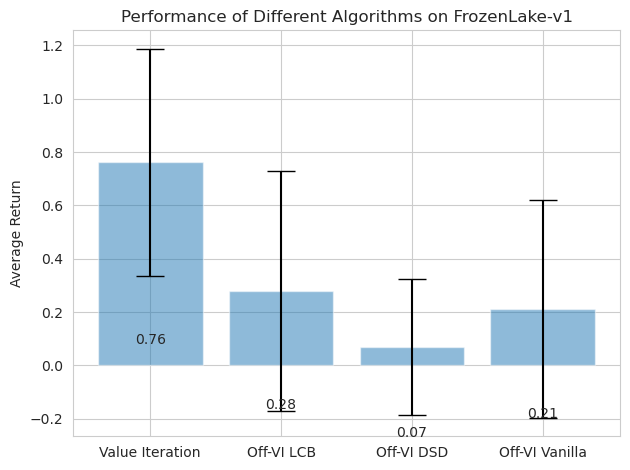

In [131]:
# Build the plot
fig, ax = plt.subplots()
bars = ax.bar(x_pos, y_val, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, )
ax.set_ylabel('Average Return')
ax.set_xticks(x_pos)
ax.set_xticklabels(names_list)
ax.set_title(f'Performance of Different Algorithms on {env.unwrapped.spec.id}')
ax.yaxis.grid(True)
# ax.set_ylim(0,1)
ax.bar_label(bars, fmt='%.2f', label_type='center', padding=-55)

# Save the figure and show
plt.tight_layout()
plt.savefig(f'ds{num_episodes}_off_perf_bar_plot_with_error_bars.png')
plt.show()

In [134]:
env = create_random_mdp()

In [147]:
env.unwrapped.__class__.__name__

'MDPToolboxEnv'

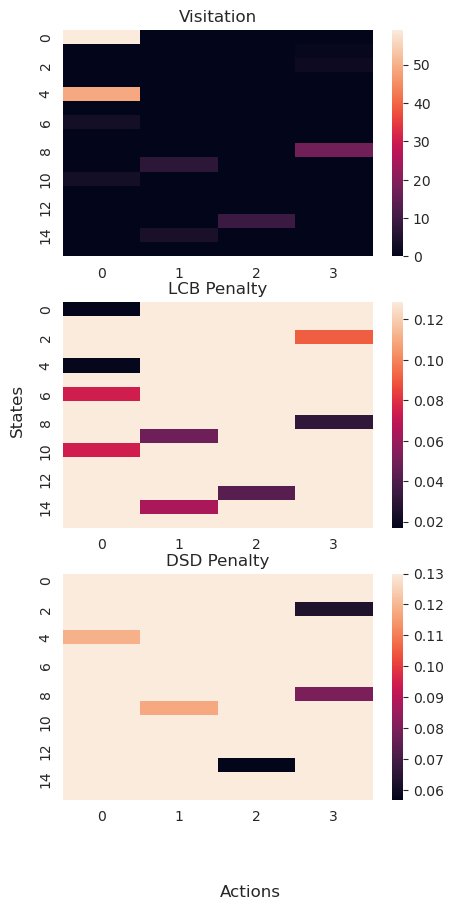

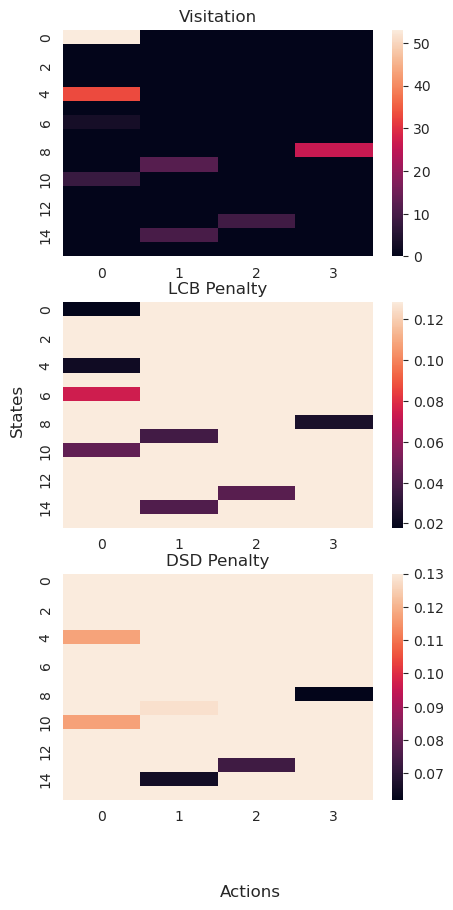

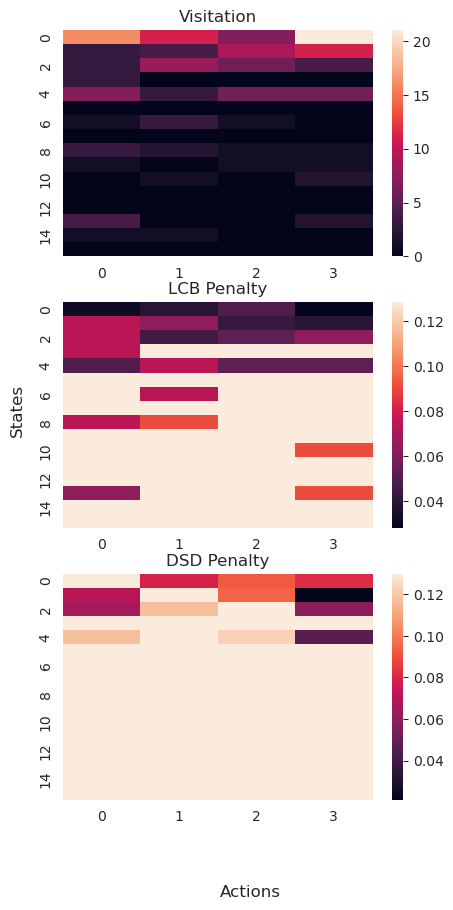

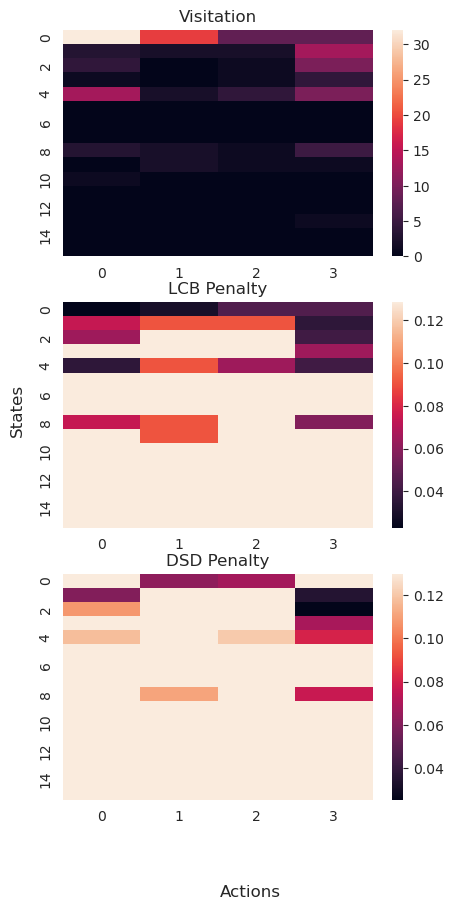

In [132]:
import seaborn as sns
import numpy as np

full_visit_mode = False

for t_ind, penalty in off_info['saved_penalty'].items():

    fig, ax = plt.subplots(3,1, figsize=(5, 10))
    fig.supxlabel('Actions')
    fig.supylabel('States')
    
    
    ax[0].title.set_text('Visitation')
    if full_visit_mode:
        visitation = off_vi_dsd.estimatePR.empirical_m_t[-1].sum(axis=-1).clip(0,100)
    else:
        visitation = off_vi_dsd.estimatePR.get_batch_mt(t_ind).sum(axis=-1).clip(0,100)
    sns.heatmap(visitation, ax=ax[0])
    
    
    
    ax[1].title.set_text('LCB Penalty')
    a = penalty#off_info_dsd['final_penalty']
    sns.heatmap(a, ax=ax[1])
    
    
    
    ax[2].title.set_text('DSD Penalty')
    a = off_info_dsd['saved_penalty'][t_ind]
    sns.heatmap(a, ax=ax[2])

    plt.savefig(f'img/ds{num_episodes}_t{t_ind}_final_penalty{"_full" if full_visit_mode else ""}.png')
# ax.imshow(a, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.show()

## Grid search for Hyperparameters

In [154]:
from d3rlpy.lcb.run import run_all_for_env
hparam_results = {}

In [155]:
np.power(10, np.linspace(-3, 2, 6))

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [156]:
np.hstack((np.power(10, np.linspace(-1, 1, 3)), [0]))

array([ 0.1,  1. , 10. ,  0. ])

In [157]:
np.power(10, np.linspace(-1, 1, 3))

array([ 0.1,  1. , 10. ])

In [158]:
np.hstack((np.power(10, np.linspace(-1, 1, 3))))

array([ 0.1,  1. , 10. ])

In [159]:
num_episodes_range=[300]#np.power(10, np.linspace(1, 4, 7)).astype(int)
lc_range=np.power(10, np.linspace(-3, 3, 13))
alpha_range=np.power(10, np.linspace(-1, 1, 3))
beta_range=np.hstack((np.power(10, np.linspace(-1, 0, 2)), [0]))
gamma_range=np.hstack((np.power(10, np.linspace(-1, 1, 3)), [None]))
seed_range = list(range(3))
v_max_range = [1, 50, 100]
known_P=False

In [164]:
!git log

commit 9b5bf9647b50247e958e09902412a400678ec4d3 (HEAD -> experimental/lcb, origin/experimental/lcb)
Author: Joe Eappen <joe.eappn@gmail.com>
Date:   Wed Jul 19 14:22:32 2023 -0400

    add mdp_toolbox_creator

commit a98655c53b624cb48d6263283c28000e0903fcb7
Author: Joe Eappen <joe.eappn@gmail.com>
Date:   Wed Jul 19 12:35:19 2023 -0400

    add exp_id to hparam run

commit e7872a4303a6071c10f424acb39a1c8995d1de88
Author: Joe Eappen <joe.eappn@gmail.com>
Date:   Wed Jul 19 12:31:31 2023 -0400

    add exp_id to hparam run

commit 840326986566b419da573800b74ee59fde86e24e
Author: Joe Eappen <joe.eappn@gmail.com>
Date:   Tue Jul 18 11:51:01 2023 -0400

    vectorize offline VI more

commit 5df7e5e898130a7d710b348c59dd97c2e2d68942
Author: Joe Eappen <joe.eappn@gmail.com>
Date:   Mon Jul 17 17:36:37 2023 -0400

    add nb

commit 5175ebe21592df7a542a35507b21bffead0bbe6b
Author: Joe Eappen <joe.eappn@gmail.com>
Date:   Mon Jul 17 17:36:30 2023 -0400

    fix vanilla off-vi hparam search

comm

    Add delayed policty update option to continuous control algorithms

commit 4a7b1c6c485ea3dc37ff0a3df1add30654db2579
Author: takuseno <takuma.seno@gmail.com>
Date:   Fri Jul 17 08:23:48 2020 +0900

    Implement Bootstrap Q functions

commit 33bdefb81ef03c18eb6a277c7a3ec0dcb9db46b2
Author: takuseno <takuma.seno@gmail.com>
Date:   Fri Jul 17 08:22:31 2020 +0900

    Rename update_temeperature to update_temp

commit 7f76165b697a151c4c92418bc13a4a485f8ac227
Author: takuseno <takuma.seno@gmail.com>
Date:   Fri Jul 17 08:21:46 2020 +0900

    Fix update_actor Q function reductio

commit 9167f0ef94bb6f406fa6809426a261dcf95b4891
Author: takuseno <takuma.seno@gmail.com>
Date:   Thu Jul 16 18:56:41 2020 +0900

    Add n_critics to discrete algorithms

commit 8d80b433c12e20fbfc20911b5644f513c4afdfea
Author: takuseno <takuma.seno@gmail.com>
Date:   Thu Jul 16 17:13:20 2020 +0900

    Implement comparers

commit d4deb6d532d0aaef181dc7147f9da918f66d6b3c
Author: takuseno <takuma.seno@gmail.com>
D

Date:   Thu Jul 2 18:45:06 2020 +0900

    Update readme

commit 30eb61225147b3de48652620b8603a652bd41e2f
Author: takuseno <takuma.seno@gmail.com>
Date:   Thu Jul 2 18:43:27 2020 +0900

    Add use_quantile_regression argument to algorithms

commit 97bdf50d6fc5b5d402046bbc7c0d4d8348cccc57
Author: takuseno <takuma.seno@gmail.com>
Date:   Thu Jul 2 17:19:43 2020 +0900

    Implement Quantile Regression Q networks

commit 0e2096b861ff0b40f17787988bceea15376a70fc
Author: takuseno <takuma.seno@gmail.com>
Date:   Thu Jul 2 17:10:17 2020 +0900

    Fix DoubleDQN target calculation

commit de3e5d9227c263bb1ae9f0f95f2389fefd5d8ba8
Author: takuseno <takuma.seno@gmail.com>
Date:   Wed Jul 1 19:43:02 2020 +0900

    Add render option to evaluate_on_environment

commit 70e6a2c973c2b888305371c80d4fbc528a9fb193
Author: takuseno <takuma.seno@gmail.com>
Date:   Wed Jul 1 19:41:57 2020 +0900

    Set use_batch_norm=True at discrete controls

commit b8a1b7af422db0f26601b55c02646dd3853ba6bb
Author: takuse

mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753


New best policy found with Lc=0.001 v_max=1 and mean score 0.086


mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_siz

New best policy found with Lc=3.1622776601683795 v_max=1 and mean score 0.138


mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753


New best policy found with Lc=3.1622776601683795 v_max=50 and mean score 0.219


mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
data

New best DSD policy found with alpha=0.1, beta=0.1, gamma=0.1 and mean score 0.053


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753


New best DSD policy found with alpha=0.1, beta=0.1, gamma=None and mean score 0.138


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753


New best DSD policy found with alpha=0.1, beta=1.0, gamma=None and mean score 0.149


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753


New best DSD policy found with alpha=1.0, beta=0.1, gamma=None and mean score 0.154


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initiali

New best DSD policy found with alpha=10.0, beta=1.0, gamma=None and mean score 0.163


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753
mb_size19 t988 batch_size19 T 987
dataset_size19351 vs 18753


New best vanilla policy found with mean score 0.147


mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677


New best policy found with Lc=0.001 v_max=1 and mean score 0.346


mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
mb_size19 t984 batch_siz

New best DSD policy found with alpha=0.1, beta=0.1, gamma=0.1 and mean score 0.03


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677


New best DSD policy found with alpha=0.1, beta=0.1, gamma=1.0 and mean score 0.033


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677


New best DSD policy found with alpha=0.1, beta=0.1, gamma=None and mean score 0.217


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677


New best DSD policy found with alpha=0.1, beta=1.0, gamma=None and mean score 0.224


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t984 batch_size19 T 983
dataset_size18718 vs 18677
INFO:d3rlpy.lcb.lcb:Initiali

New best DSD policy found with alpha=10.0, beta=0.0, gamma=None and mean score 0.231
New best vanilla policy found with mean score 0.212


mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694


New best policy found with Lc=0.001 v_max=1 and mean score 0.071


mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694


New best policy found with Lc=0.01 v_max=50 and mean score 0.091


mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
mb_size18 t984 batch_siz

New best DSD policy found with alpha=0.1, beta=0.1, gamma=0.1 and mean score 0.055


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694


New best DSD policy found with alpha=0.1, beta=0.1, gamma=None and mean score 0.131


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initiali

New best DSD policy found with alpha=1.0, beta=0.1, gamma=1.0 and mean score 0.147


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t984 batch_size18 T 983
dataset_size18623 vs 17694
INFO:d3rlpy.lcb.lcb:Initiali

New best vanilla policy found with mean score 0.075
{'mean': 0.751, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.4324338099640221} {'mean': 0.071, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.2568248430350927} {'mean': 0.153, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.3599874997829786} {'mean': 0.071, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.2568248430350927}


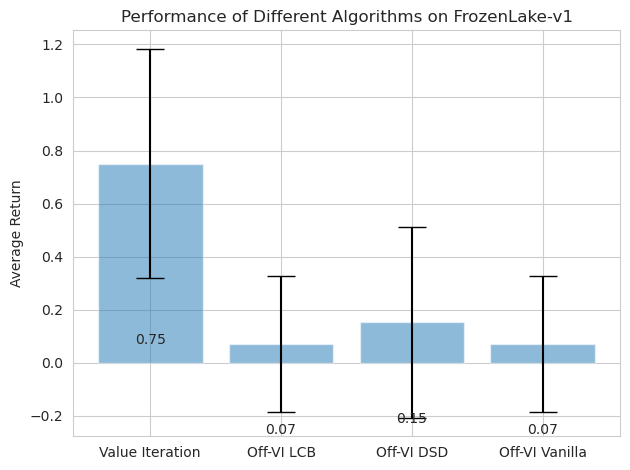

In [165]:
for num_episodes in num_episodes_range:
    hparam_results[num_episodes] = run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
               known_p=False, seed_range=seed_range, v_max_range=v_max_range)

In [82]:
lc_range

array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])

In [83]:
num_episodes=300

In [85]:
run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
               known_p=False, seed_range=seed_range, env_creator=create_random_mdp)

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.001 v_max=1 and mean score 5.151013064856004


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.0031622776601683794 v_max=1 and mean score 5.477624819218549


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.01 v_max=1 and mean score 5.565998334340408


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.03162277660168379 v_max=1 and mean score 5.692074441495278


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.1 v_max=1 and mean score 14.932588580047554


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


KeyboardInterrupt: 

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.001 and mean score 49.423790856282615


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.0031622776601683794 and mean score 49.647040734592665


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best DSD policy found with alpha=0.1, beta=0.1, gamma=0.1 and mean score 49.20922878908113


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best DSD policy found with alpha=0.1, beta=0.1, gamma=1.0 and mean score 49.57485586213716


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best DSD policy found with alpha=0.1, beta=0.0, gamma=0.1 and mean score 49.59648150351878


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best DSD policy found with alpha=0.1, beta=0.0, gamma=1.0 and mean score 49.70837538931367


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlp

New best DSD policy found with alpha=10.0, beta=0.1, gamma=0.1 and mean score 49.97875602695863


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlp

New best vanilla policy found with mean score 49.36273804974478


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_si

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best policy found with Lc=0.001 and mean score 49.8648422073294


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
data

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Init

New best vanilla policy found with mean score 49.24302924160553


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_si

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best vanilla policy found with mean score 49.320699592553744


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_si

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best vanilla policy found with mean score 49.37330187179276


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_si

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


New best vanilla policy found with mean score 49.6086401881309


mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_si

mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3r

INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3r

INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920
mb_size78 t1141 batch_size78 T 1140
dataset_size90000 vs 88920


{'mean': 49.45818495918052, 'median': 49.398259197876854, 'min': 33.82707525805841, 'max': 65.69262764800172, 'std': 4.702318127274066} {'mean': 49.5027886021874, 'median': 49.412239628536284, 'min': 33.62533401809115, 'max': 62.48266109461539, 'std': 4.732500626626953} {'mean': 49.47631915693265, 'median': 49.44448919094866, 'min': 36.096955873674204, 'max': 64.72980008957656, 'std': 4.6357436858198735} {'mean': 49.67327370115065, 'median': 49.94342082289134, 'min': 31.62028034034992, 'max': 65.69855277104273, 'std': 4.782524979728253}


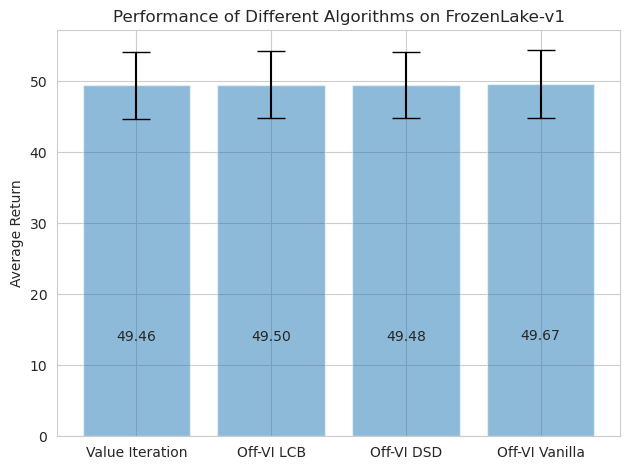

In [89]:
run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
               known_p=False, seed_range=seed_range, env_creator=lambda: MDPToolboxEnv(P_norm, R))

mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734


New best policy found with Lc=0.001 and mean score 0.313


mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known t

New best DSD policy found with alpha=0.1, beta=0.1, gamma=0.1 and mean score 0.056


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation


New best DSD policy found with alpha=0.1, beta=0.1, gamma=10.0 and mean score 0.104


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation


New best DSD policy found with alpha=0.1, beta=0.1, gamma=None and mean score 0.672


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t987 batch_size19 T 986
dataset_size19187 vs 18734
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t98

New best vanilla policy found with mean score 0.653


mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb

mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size18 t980 batch_size18 T 979
dataset_size17901 vs 17622

New best DSD policy found with alpha=10.0, beta=0.0, gamma=None and mean score 0.674


mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb

mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size19 t990 batch_size19 T 989
dataset_size19754 vs 18791

{'mean': 0.76, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.4270831300812524} {'mean': 0.288, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.45283109433871693} {'mean': 0.636, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.4811486256864921} {'mean': 0.656, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.47504105085771264}


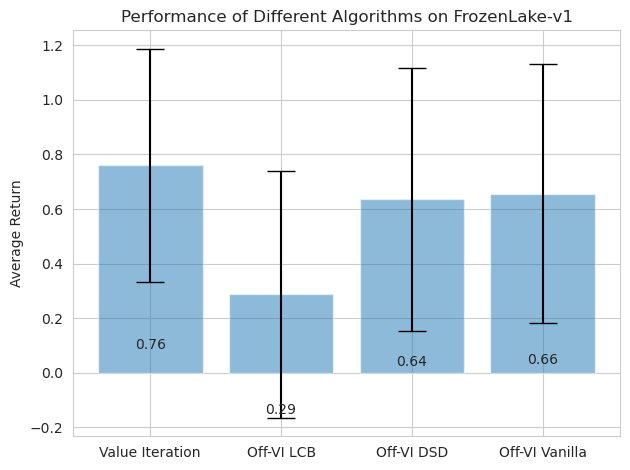

In [59]:
run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
               known_p=True, seed_range=seed_range)

In [63]:
num_episodes=30000
run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
               known_p=False, seed_range=seed_range)


New best policy found with Lc=0.001 and mean score 0.437
New best policy found with Lc=0.0031622776601683794 and mean score 0.705


INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/yokian/anaconda3/envs/off_rl/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_207636/1573286398.py", line 2, in <module>
    run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
  File "/home/yokian/PycharmProjects/offline-rl/d3rlpy/lcb/run.py", line 67, in run_all_for_env
    off_policy_dsd, off_V_s_dsd, off_info_dsd = off_vi_dsd.offline_value_iteration(N=ds.dataset_size,
  File "/home/yokian/PycharmProjects/offline-rl/d3rlpy/lcb/lcb.py", line 296, in offline_value_iteration
    penalty = self._calc_penalty(t, v_max=V_max, L=L, known_p=known_P)
  File "/home/yokian/PycharmProjects/offline-rl/d3rlpy/lcb/lcb.py", line 459, in _calc_penalty
    sas_count = ind[(s, a, _s_next)].clip(clip_count)  # NOTE: clip when using unbiased estimator
  File "/home/yokian/an

mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589


New best policy found with Lc=0.001 and mean score 0.067


mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
IN

New best DSD policy found with alpha=0.1, beta=0.1, gamma=0.1 and mean score 0.041


mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD


New best DSD policy found with alpha=0.1, beta=0.1, gamma=None and mean score 0.242


mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153

New best DSD policy found with alpha=0.1, beta=0.0, gamma=None and mean score 0.367


mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153 T 1213
dataset_size186291 vs 185589
INFO:d3rlpy.lcb.lcb:Using known transition probabilities in penalty calculation
INFO:d3rlpy.lcb.lcb:Initializing OfflineVIwDSD
mb_size153 t1214 batch_size153

New best vanilla policy found with mean score 0.664
{'mean': 0.753, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.4312667388055796} {'mean': 0.078, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.26817158686184484} {'mean': 0.398, 'median': 0.0, 'min': 0.0, 'max': 1.0, 'std': 0.4894854441145313} {'mean': 0.657, 'median': 1.0, 'min': 0.0, 'max': 1.0, 'std': 0.4747114913292073}


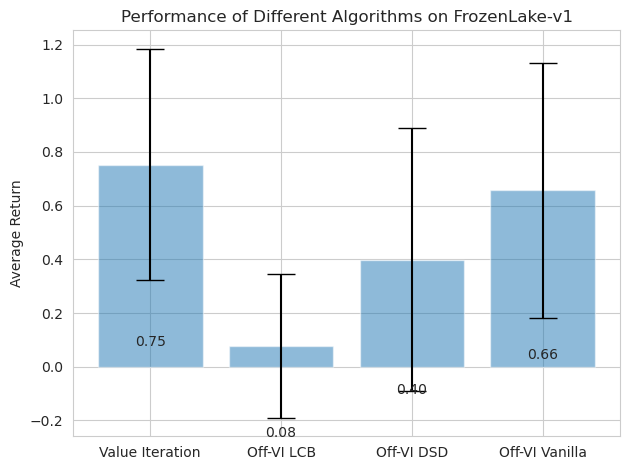

In [61]:
run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
               known_p=True)

In [90]:
num_episodes=30
for known_p in [True, False]:
    run_all_for_env(num_episodes, lc_range=lc_range, alpha_range=alpha_range, beta_range=beta_range, gamma_range=gamma_range,
                   known_p=known_p, seed_range=seed_range)

mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488


New best policy found with Lc=0.001 and mean score 0.0
New best policy found with Lc=0.0031622776601683794 and mean score 0.032


mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488


New best policy found with Lc=0.01 and mean score 0.055


mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488
mb_size2 t745 batch_size2 T 744
dataset_size1715 vs 1488


TypeError: __init__() missing 1 required keyword-only argument: 'sample_data_for_gamma'